In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('C:\\Users\\Roby\\Desktop\\gpa'):
   # for filename in filenames:
       # print(os.path.join(dirname, filename))


# Import Libraries

In [7]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings for clarity

# Load, Explore, and Preprocess Data

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Student_ID                       2000 non-null   int64  
 1   Study_Hours_Per_Day              2000 non-null   float64
 2   Extracurricular_Hours_Per_Day    2000 non-null   float64
 3   Sleep_Hours_Per_Day              2000 non-null   float64
 4   Social_Hours_Per_Day             2000 non-null   float64
 5   Physical_Activity_Hours_Per_Day  2000 non-null   float64
 6   GPA                              2000 non-null   float64
 7   Stress_Level                     2000 non-null   object 
dtypes: float64(6), int64(1), object(1)
memory usage: 125.1+ KB
None

Missing Values per Column:
 Student_ID                         0
Study_Hours_Per_Day                0
Extracurricular_Hours_Per_Day      0
Sleep_Hours_Per_Day                0
Social_Hours_

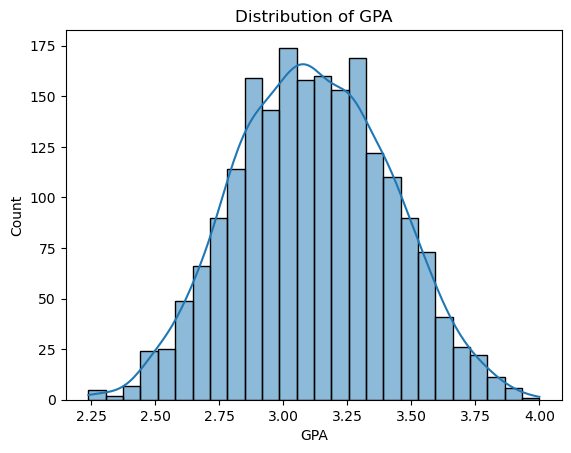

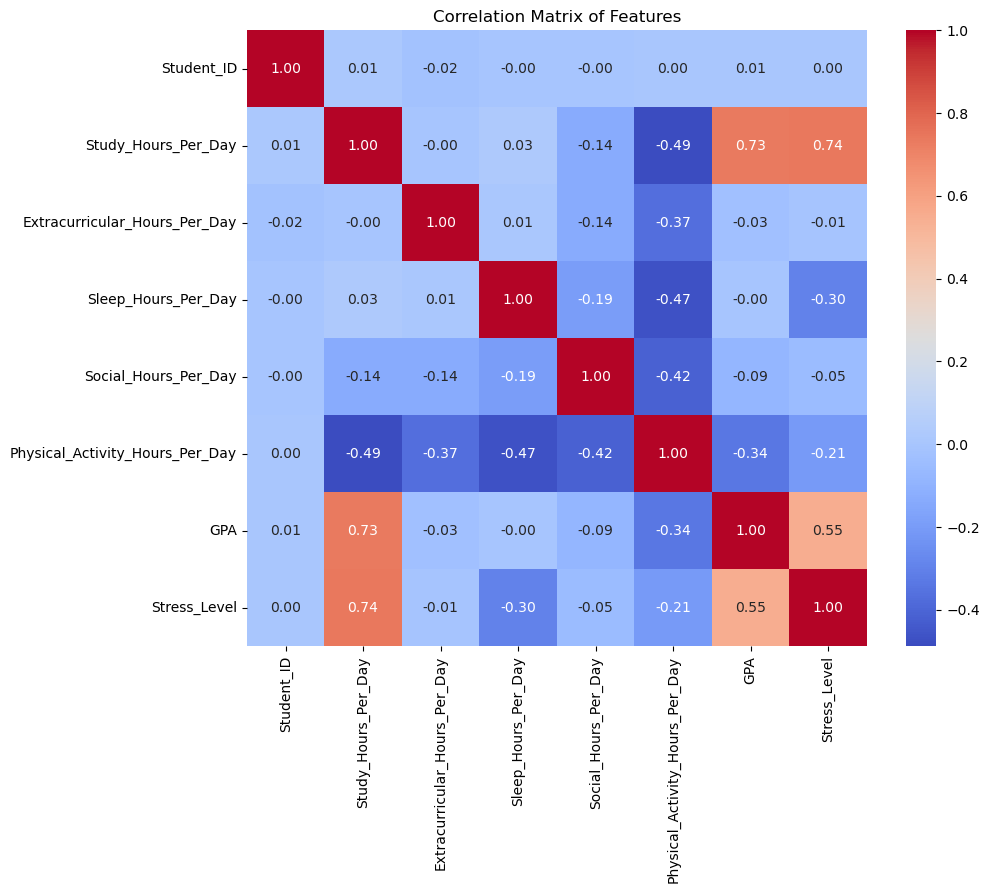

In [11]:
# Load and preprocess the data
def load_and_preprocess_data(filepath):
    # Load dataset
    data = pd.read_csv(filepath)
    
    # Display dataset info and check for missing values
    print("Data Overview:")
    print(data.info())
    print("\nMissing Values per Column:\n", data.isnull().sum())

    # Initial statistics and visualization of target
    print("\nSummary Statistics:\n", data.describe())
    sns.histplot(data['GPA'], kde=True)
    plt.title("Distribution of GPA")
    plt.show()

    # Convert categorical 'Stress_Level' to numeric
    data['Stress_Level'] = data['Stress_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

    # Correlation matrix visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix of Features")
    plt.show()

    # Separate features and target
    X = data[['Study_Hours_Per_Day', 'Extracurricular_Hours_Per_Day', 'Sleep_Hours_Per_Day',
              'Social_Hours_Per_Day', 'Physical_Activity_Hours_Per_Day', 'Stress_Level']]
    y = data['GPA']
    
    # Handle missing values and standardize features
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Polynomial transformation
    ])

    X_processed = pipeline.fit_transform(X)
    feature_names = pipeline.named_steps['poly'].get_feature_names_out(input_features=X.columns)
    return X_processed, y, feature_names

# Load data and preprocess
X_processed, y, feature_names = load_and_preprocess_data('student_lifestyle_dataset.csv')

# Train-test Split

In [16]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Model Training, Evaluation, and Cross-Validation

In [18]:
# Model training and evaluation with cross-validation
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(),
        'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    results = {}
    for name, model in models.items():
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        print(f"{name} - Cross-validated R2 Score: {np.mean(cv_scores):.4f}")

        # Train and evaluate model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = {'MSE': mse, 'R2': r2, 'MAE': mae}
    
    return pd.DataFrame(results).T

# Train and evaluate models
results_df = train_and_evaluate_models(X_train, X_test, y_train, y_test)
print("\nModel Evaluation Results:\n", results_df)

Linear Regression - Cross-validated R2 Score: 0.5309
Ridge Regression - Cross-validated R2 Score: 0.5305
Lasso Regression - Cross-validated R2 Score: 0.4203
Random Forest - Cross-validated R2 Score: 0.4851
Gradient Boosting - Cross-validated R2 Score: 0.5044
XGBoost - Cross-validated R2 Score: 0.3887

Model Evaluation Results:
                         MSE        R2       MAE
Linear Regression  0.043285  0.536379  0.165830
Ridge Regression   0.043269  0.536555  0.165861
Lasso Regression   0.053497  0.427003  0.187414
Random Forest      0.050470  0.459423  0.180103
Gradient Boosting  0.046156  0.505632  0.170932
XGBoost            0.060327  0.353852  0.195584


# Hyperparameter Tuning for RandomForestRegressor

In [23]:
# Hyperparameter tuning for RandomForestRegressor
def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    grid_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), param_grid, 
                                     cv=5, scoring='r2', n_iter=10, n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train)
    best_rf_model = grid_search.best_estimator_
    return best_rf_model, grid_search.best_params_

# Tune the Random Forest model
best_rf_model, best_params = tune_random_forest(X_train, y_train)
print("Best Random Forest Parameters:", best_params)

Best Random Forest Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}


# Evaluate the Tuned Model on Test Set

In [25]:
# Evaluate the tuned model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
print("\nBest Random Forest Model Evaluation on Test Set:")
print(f"R2 Score: {r2_score(y_test, y_pred_best_rf):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_best_rf):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_best_rf):.4f}")


Best Random Forest Model Evaluation on Test Set:
R2 Score: 0.4855
Mean Squared Error: 0.0480
Mean Absolute Error: 0.1766


# Permutation Importance for Feature Analysis

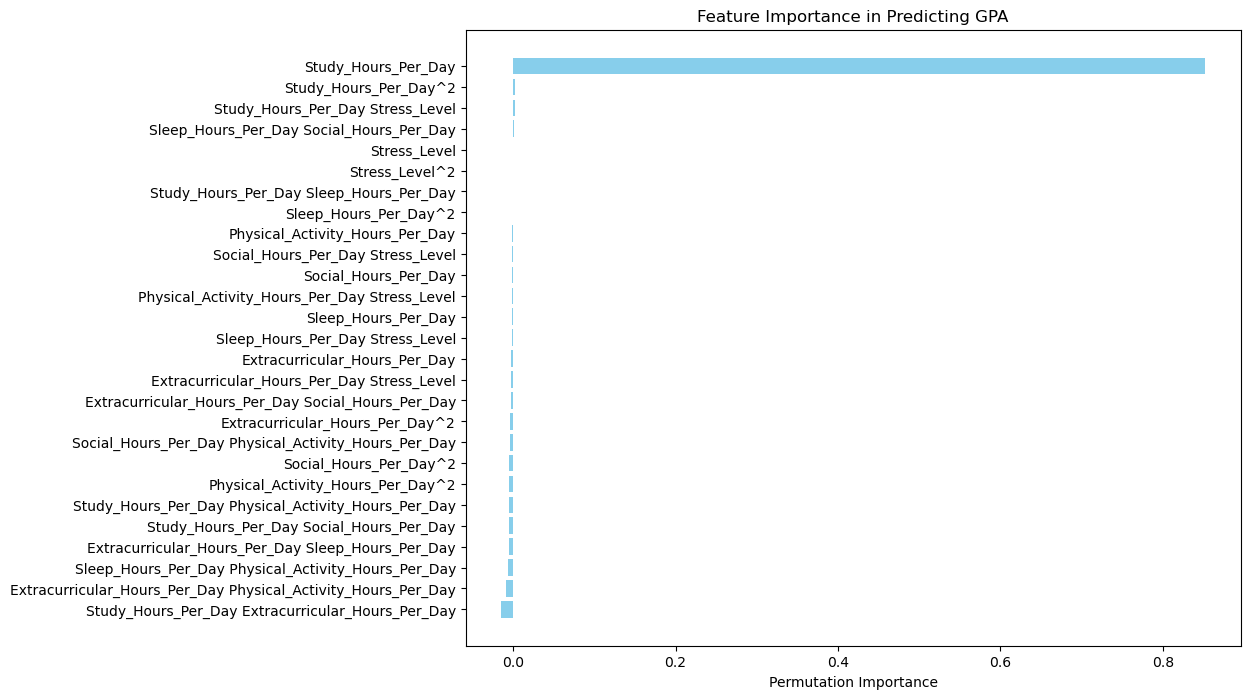

In [26]:
# Feature importance with permutation importance
def plot_permutation_importance(model, X_test, y_test, feature_names):
    importances = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    sorted_indices = importances.importances_mean.argsort()

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(sorted_indices)), importances.importances_mean[sorted_indices], color="skyblue")
    plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance in Predicting GPA")
    plt.show()

# Plot permutation importance for the best Random Forest model
plot_permutation_importance(best_rf_model, X_test, y_test, feature_names)

# SHAP Summary Plot for Model Interpretability

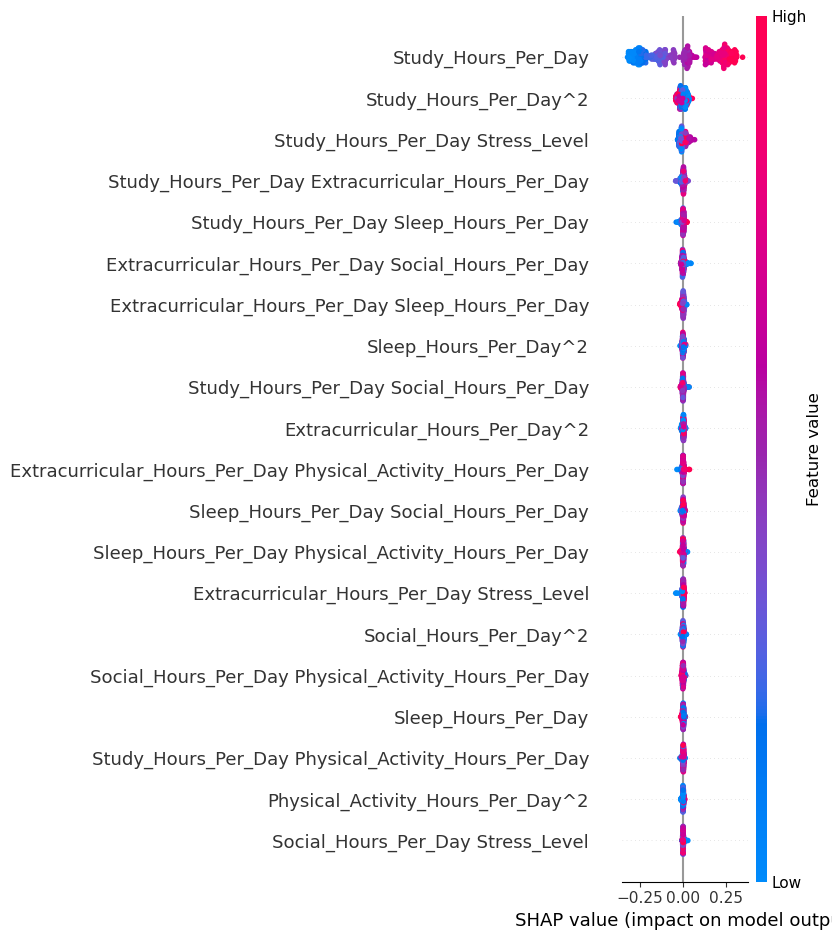

In [27]:
# SHAP summary plot for model interpretability
def plot_shap_summary(model, X_test, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Plot SHAP summary for the best Random Forest model
plot_shap_summary(best_rf_model, X_test, feature_names)

# Visualization of Model Performance Across Models

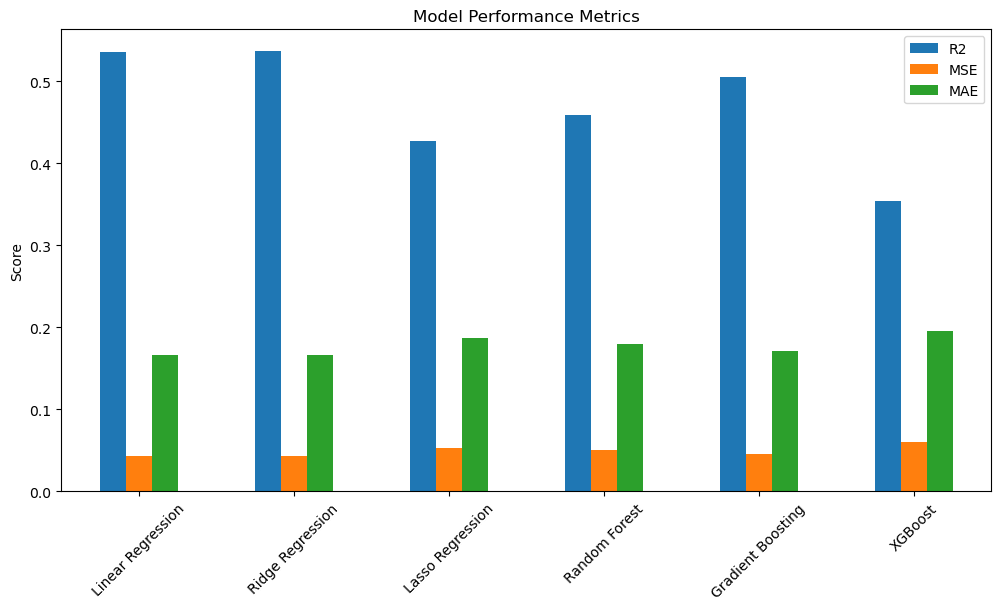

In [28]:
# Visualization of model performance
def plot_model_performance(results_df):
    results_df[['R2', 'MSE', 'MAE']].plot(kind='bar', figsize=(12, 6), title="Model Performance Metrics")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.show()

# Plot performance metrics for each model
plot_model_performance(results_df)

# Display Final Summary

In [21]:
# Display final results for all models and best tuned model
print("\nComprehensive Model Evaluation Results:\n", results_df)
print("\nBest Random Forest Model Evaluation Metrics on Test Set:")
print(f"R2 Score: {r2_score(y_test, y_pred_best_rf):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_best_rf):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_best_rf):.4f}")


Comprehensive Model Evaluation Results:
                         MSE        R2       MAE
Linear Regression  0.043275  0.536491  0.165977
Ridge Regression   0.043269  0.536555  0.165861
Lasso Regression   0.053497  0.427003  0.187414
Random Forest      0.050470  0.459423  0.180103
Gradient Boosting  0.046169  0.505494  0.171039
XGBoost            0.060327  0.353852  0.195584

Best Random Forest Model Evaluation Metrics on Test Set:
R2 Score: 0.4855
Mean Squared Error: 0.0480
Mean Absolute Error: 0.1766


In [5]:
!pip install shap

  Using cached shap-0.46.0-cp312-cp312-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.46.0-cp312-cp312-win_amd64.whl (456 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
